In [1]:
# IMPORTING THE LIBRARIES
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


Text(0.5, 1.0, 'Is Not Stationary')

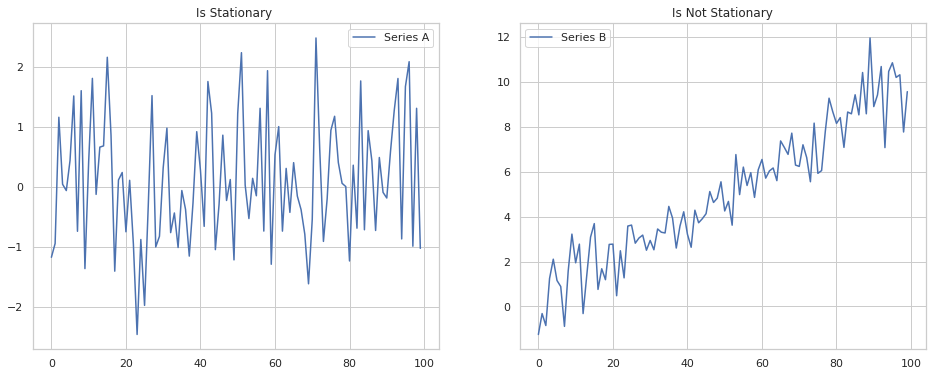

In [3]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)

T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows =1, ncols =2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Is Stationary ')
ax2.set_title('Is Not Stationary')

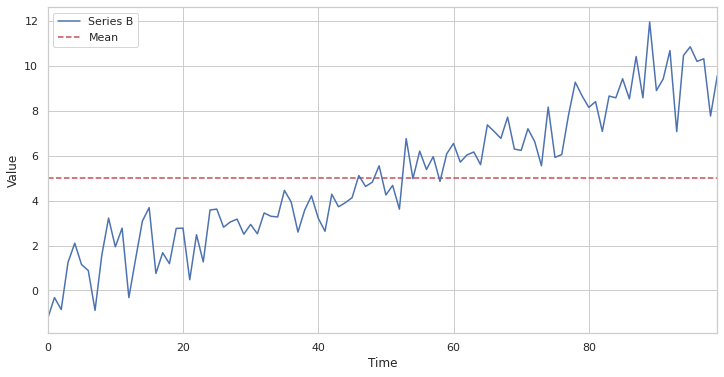

In [4]:
mean = np.mean(B)

plt.figure(figsize=(12,6))
plt.plot(B)
plt.hlines(mean, 0, len(B), linestyles='dashed', colors = 'r')
plt.xlabel('Time')
plt.xlim([0, 99])
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

In [5]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [6]:
stationarity_test(A)
stationarity_test(B)

p-value = 3.887265622172797e-18 The series A is likely stationary.
p-value = 0.9805436679919122 The series B is likely non-stationary.


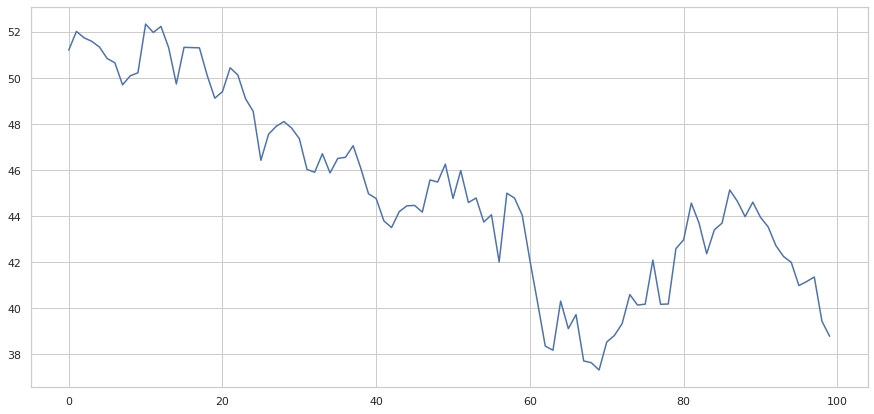

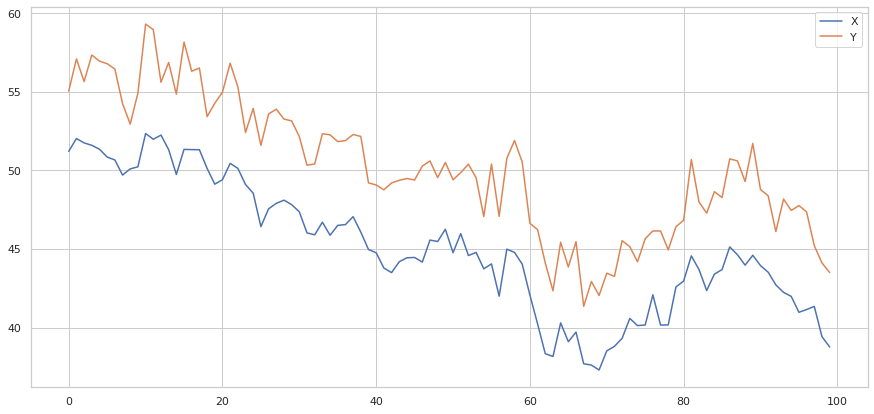

In [7]:
# Generate daily returns

Xreturns = np.random.normal(0, 1, 100)

# sum up and shift the prices up

X = pd.Series(np.cumsum(
    Xreturns), name='X') + 50
X.plot(figsize=(15,7))

noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'

pd.concat([X, Y], axis=1).plot(figsize=(15, 7))

plt.show()

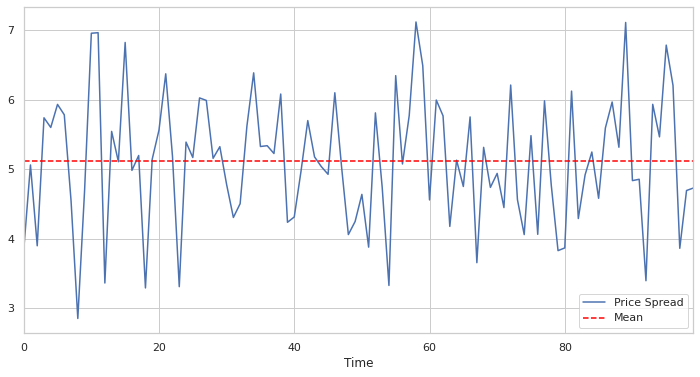

In [8]:
plt.figure(figsize=(12,6))
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.xlim(0,99)
plt.legend(['Price Spread', 'Mean']);

In [9]:
score, pvalue, _ = coint(X,Y)
print(pvalue)

# Low pvalue means high cointegration!

8.72285440336762e-15


(0.0, 99.0)

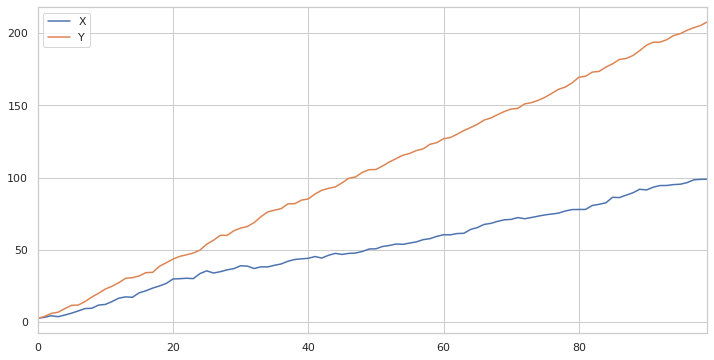

In [10]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')


pd.concat([X_diverging, Y_diverging], axis=1).plot(figsize=(12,6));
plt.xlim(0, 99)


In [11]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.9960204231046332
Cointegration test p-value: 0.286648580634552


Correlation: -0.006636228410256069
Cointegration test p-value: 0.0


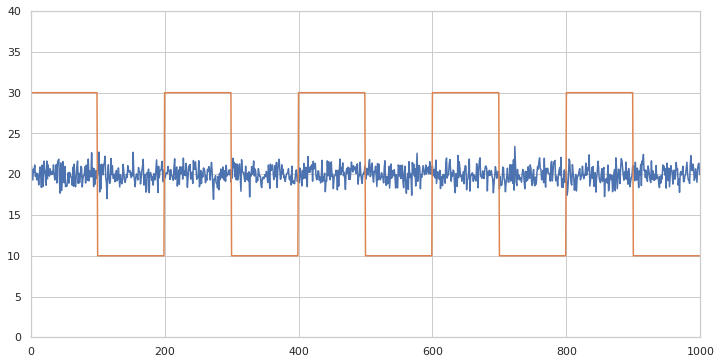

In [12]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10


plt.figure(figsize=(12,6))
Y2.plot()
Y3.plot()
plt.ylim([0, 40])
plt.xlim([0, 1000]);

# correlation is nearly zero
print( 'Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print( 'Cointegration test p-value: ' + str(pvalue))

In [13]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
!pip install yfinance
import yfinance as yf

yf.pdr_override()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [14]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [15]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2022, 9, 13)

tickers = ['BARC.L','HSBA.L','LLOY.L','MTRO.L','NWG','STAN.L','VMUK.L']


df1 = pdr.get_data_yahoo(tickers, start, end)['Close']



df1.head()



[*********************100%***********************]  7 of 7 completed


,BARC.L,HSBA.L,LLOY.L,MTRO.L,NWG,STAN.L,VMUK.L
Date,,,,,,,
2020-01-02,185.199997,595.099976,63.709999,209.199997,6.993534,720.000000,190.949997
2020-01-03,183.300003,594.400024,63.049999,201.000000,6.713362,720.799988,187.800003
2020-01-06,180.979996,585.200012,63.250000,196.600006,6.842672,707.000000,184.300003
2020-01-07,183.139999,583.400024,63.110001,207.399994,6.799569,701.599976,180.850006
2020-01-08,182.039993,581.299988,62.790001,207.000000,6.821121,698.799988,180.000000


In [16]:
df = df1.dropna()
df

,BARC.L,HSBA.L,LLOY.L,MTRO.L,NWG,STAN.L,VMUK.L
Date,,,,,,,
2020-01-02,185.199997,595.099976,63.709999,209.199997,6.993534,720.000000,190.949997
2020-01-03,183.300003,594.400024,63.049999,201.000000,6.713362,720.799988,187.800003
2020-01-06,180.979996,585.200012,63.250000,196.600006,6.842672,707.000000,184.300003
2020-01-07,183.139999,583.400024,63.110001,207.399994,6.799569,701.599976,180.850006
2020-01-08,182.039993,581.299988,62.790001,207.000000,6.821121,698.799988,180.000000
...,...,...,...,...,...,...,...
2022-09-06,167.880005,533.700012,45.230000,86.599998,5.960000,602.599976,152.800003
2022-09-07,164.100006,523.000000,44.674999,85.099998,6.000000,576.799988,147.649994
2022-09-08,166.259995,525.500000,45.230000,87.300003,5.970000,592.799988,152.550003


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 661 entries, 2020-01-02 to 2022-09-12
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BARC.L  661 non-null    float64
 1   HSBA.L  661 non-null    float64
 2   LLOY.L  661 non-null    float64
 3   MTRO.L  661 non-null    float64
 4   NWG     661 non-null    float64
 5   STAN.L  661 non-null    float64
 6   VMUK.L  661 non-null    float64
dtypes: float64(7)
memory usage: 41.3 KB


# New section

[('BARC.L', 'VMUK.L'), ('MTRO.L', 'NWG'), ('MTRO.L', 'VMUK.L')]


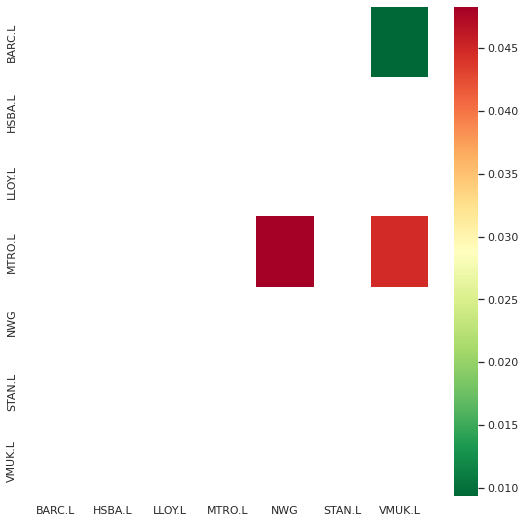

In [18]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(9,9))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [19]:

pd.Series('NWG')

plt.show()

In [20]:
S1 = df['BARC.L']
S2 = df['VMUK.L']

score, pvalue, _ = coint(S1, S2)
pvalue


0.00934891921153337

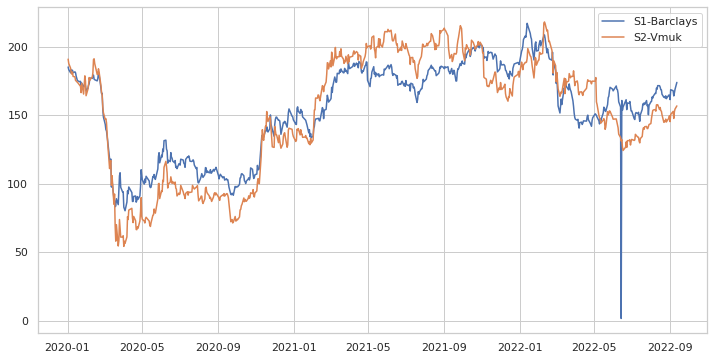

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(S1)
plt.plot(S2)

plt.legend(['S1-Barclays', 'S2-Vmuk'])


plt.show()

In [22]:
stationarity_test(S1)
stationarity_test(S2)

p-value = 0.36240166183329514 The series BARC.L is likely non-stationary.
p-value = 0.5130414330456198 The series VMUK.L is likely non-stationary.


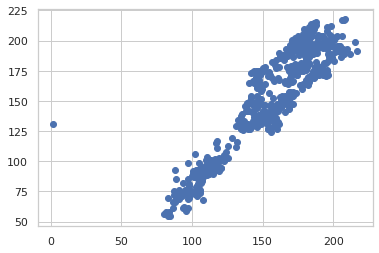

In [23]:
plt.scatter(S1, S2)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


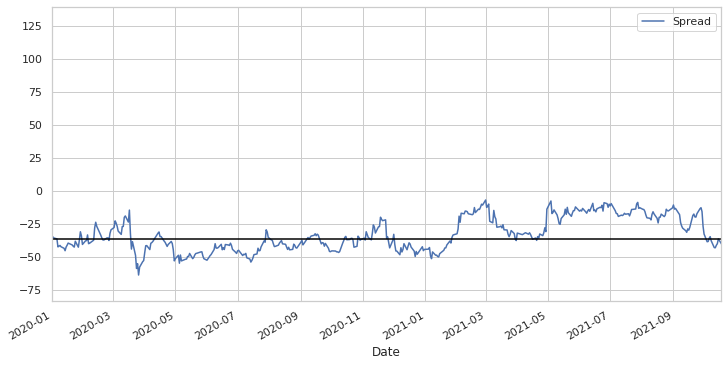

In [24]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['BARC.L']
b = results.params['BARC.L']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2020-01-01', '2021-10-18')
plt.legend(['Spread']);

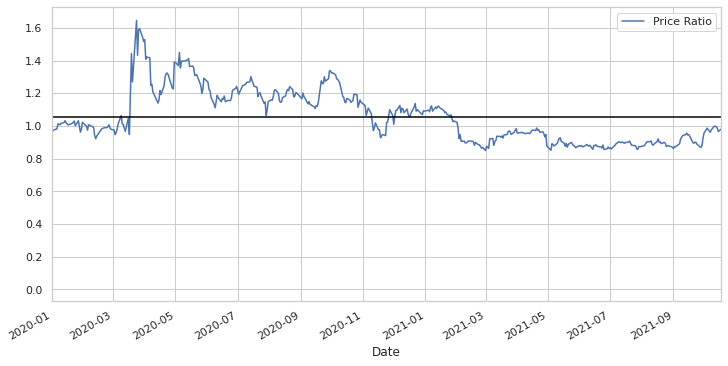

In [25]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2020-01-01', '2021-10-18')
plt.legend(['Price Ratio']);

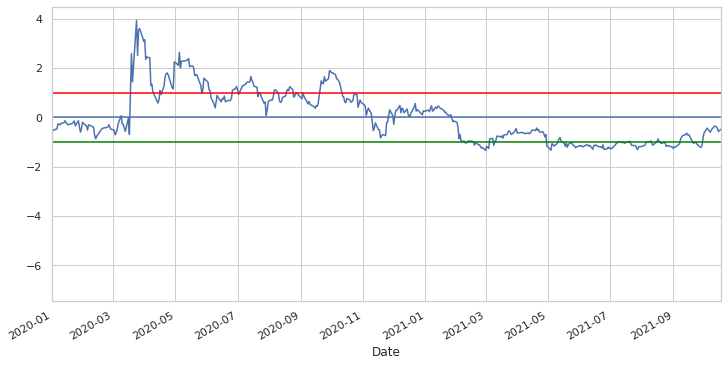

In [26]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2020-01-01', '2021-10-18')
plt.show()

In [27]:
ratios = df['BARC.L'] / df['VMUK.L'] 
print(len(ratios) * .70 ) 

462.7


In [28]:
train = ratios[:457]
test = ratios[457:]

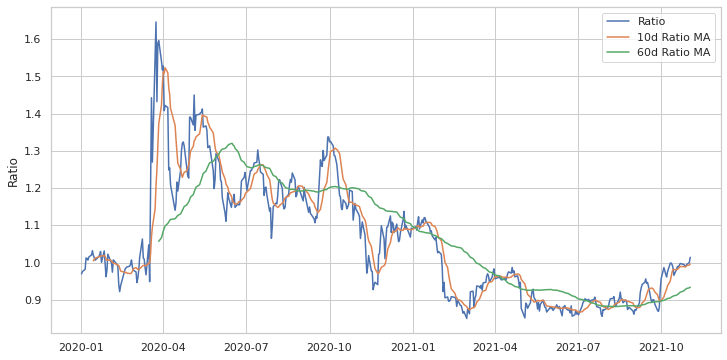

In [29]:
ratios_mavg10 = train.rolling(window=10, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_10 = (ratios_mavg10 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg10.index, ratios_mavg10.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '10d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

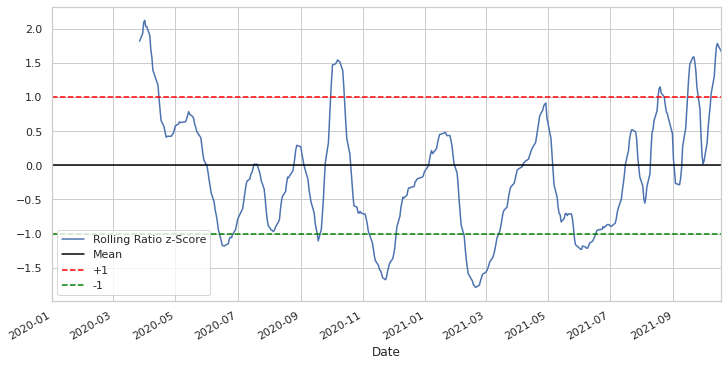

In [30]:
plt.figure(figsize=(12,6))
zscore_60_10.plot()
plt.xlim('2020-01-01', '2021-10-18')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

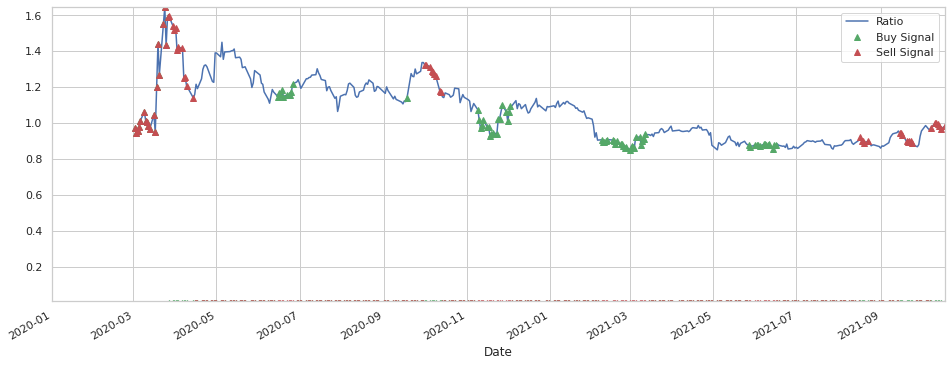

In [31]:
plt.figure(figsize=(16,6))

train[40:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_10>-1] = 0
sell[zscore_60_10<1] = 0
buy[40:].plot(color='g', linestyle='None', marker='^')
sell[40:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2020-01-01','2021-10-18')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

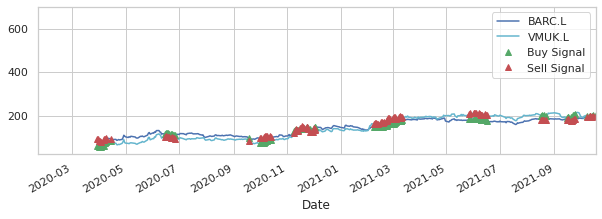

In [32]:
plt.figure(figsize=(10,3))
S1 = df['BARC.L'].iloc[:457]
S2 = df['VMUK.L'].iloc[:457]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]



# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(25, 700)
plt.xlim('2020-01-22', '2021-10-18')

plt.legend(['BARC.L', 'VMUK.L', 'Buy Signal', 'Sell Signal'])
plt.show()

In [33]:
from pandas.core.dtypes.cast import maybe_cast_to_integer_array
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    i=0
    if (window1 == i) or (window2 == i):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
   

  


    # Simulate trading
    # Start with no money and no positions
    money = 550
    countS1 = 0
    countS2 = 0
  
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            (print('buy  %s  %s'%(money, countS1)))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('sell   %s %s'%(money, countS1))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            
            print('Exit pos %s %s'%(money, countS1))
       
        
    
            
    return ('profit is' ,money)
   


In [34]:
trade(df['BARC.L'].iloc[457:], df['VMUK.L'].iloc[457:], 60, 5)


sell   550.0 1
sell   550.0 2
sell   550.0 3
sell   550.0 4
sell   550.0 5
sell   550.0 6
sell   550.0 7
sell   550.0 8
sell   550.0 9
sell   550.0 10
sell   550.0 11
sell   550.0 12
sell   550.0 13
sell   550.0 14
sell   550.0 15
sell   550.0 16
sell   550.0 17
sell   550.0 18
sell   550.0 19
sell   550.0 20
sell   550.0 21
sell   550.0 22
sell   550.0 23
sell   550.0 24
sell   550.0 25
sell   550.0 26
sell   550.0 27
sell   550.0 28
sell   550.0 29
sell   550.0 30
sell   550.0 31
sell   550.0 32
sell   550.0 33
sell   550.0 34
sell   550.0 35
sell   550.0 36
sell   550.0 37
sell   550.0 38
sell   550.0 39
sell   550.0 40
sell   550.0 41
sell   550.0 42
sell   550.0 43
sell   550.0 44
sell   550.0 45
sell   550.0 46
sell   550.0 47
sell   550.0 48
sell   550.0 49
sell   550.0 50
sell   550.0 51
sell   550.0 52
sell   550.0 53
sell   550.0 54
sell   550.0 55
sell   550.0 56
sell   550.0 57
sell   550.0 58
sell   550.0 59
sell   550.0 60
sell   550.0 61
Exit pos 733.9616458932178 0
Exit

('profit is', 3836.8419906496947)

In [36]:
return_df = df.pct_change()
return_df
#plt.plot(return_df('BARC.L','VMUK.L'))
#plt.show()


,BARC.L,HSBA.L,LLOY.L,MTRO.L,NWG,STAN.L,VMUK.L
Date,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.010259,-0.001176,-0.010359,-0.039197,-0.040062,0.001111,-0.016496
2020-01-06,-0.012657,-0.015478,0.003172,-0.021891,0.019262,-0.019145,-0.018637
2020-01-07,0.011935,-0.003076,-0.002213,0.054934,-0.006299,-0.007638,-0.018719
2020-01-08,-0.006006,-0.003600,-0.005071,-0.001929,0.003170,-0.003991,-0.004700
...,...,...,...,...,...,...,...
2022-09-06,-0.004507,-0.002243,0.034656,0.056098,0.031142,0.000000,0.015282
2022-09-07,-0.022516,-0.020049,-0.012271,-0.017321,0.006711,-0.042814,-0.033704
2022-09-08,0.013163,0.004780,0.012423,0.025852,-0.005000,0.027739,0.033187


In [37]:
volatility = return_df.std()
volatility

BARC.L    3.953233
HSBA.L    0.021164
LLOY.L    0.025888
MTRO.L    0.044103
NWG       0.030623
STAN.L    0.026932
VMUK.L    0.041799
dtype: float64